In [29]:
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, BayesianRidge, TweedieRegressor
from sklearn.svm import SVR
from sklearn.tree import ExtraTreeRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

from pykrige.rk import RegressionKriging
from pykrige.ok import OrdinaryKriging
from pykrige.uk import UniversalKriging
import gstools as gs

import warnings
warnings.simplefilter(action='ignore')

## Функция

In [30]:
"""
Удаление выбросов с использованием межквартильного размаха (IQR)
"""
def get_filter_df(df, col):
    # Определяем Q1 и Q3 квартили
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    
    # Вычисляем IQR
    IQR = Q3 - Q1
    
    # Определяем границы для определения выбросов
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Фильтруем выбросы
    return df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

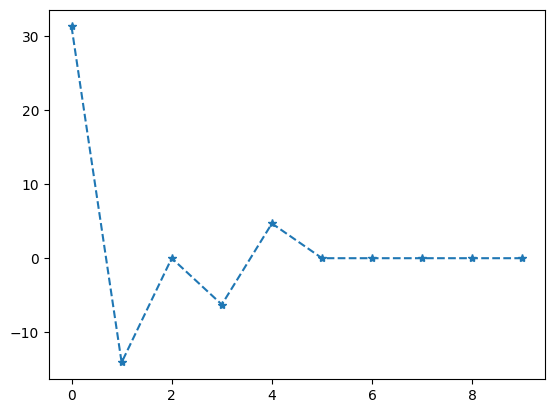

125.0 125.0


In [31]:
"""
Получение значений корреляции
"""
def get_corr(points, values, max_h, start=0, step=1):
    def matrix_distance_and_value(points, values):

        l = len(points)
        D = np.zeros((l, l))
        V = np.zeros((l, l))
        M = np.mean(values)

        for i in range(l):
            for j in range(i, l):
                distance = np.linalg.norm(points[i] - points[j])
                D[i, j] = distance
                V[i, j] = (values[i]-M)*(values[j]-M)
        return D, V
    
    
    corr_list, h_list = [], []
    D, V = matrix_distance_and_value(points, values)
    
    for h in range(start, max_h, step):
        corr_list.append(np.mean(np.where((D <= h) & (D > h-step), V, 0)))
        h_list.append(h)
    
    return np.array(h_list), np.array(corr_list)


# Пример построения корр функции
B = np.array([[1, 2, 3], [3, 4, 5], [1, 5, 7], [1, 2, 4]])
V = np.array([10, 20, 30, 40])
x, y = get_corr(B, V, 10)
plt.plot(x, y, "--*")
plt.show()
print(np.var(V), y[0]*4)

In [32]:
def my_R2(y_true, y_pred, y_mean):
    mse1 = mean_squared_error(y_true, y_pred)
    mse2 = mean_squared_error(y_true, [y_mean] * y_true.shape[0])
    return 1 - mse1/mse2

# example
y1 = np.array([1, 2, 3, 4, 5])
y2 = np.array([2, 2, 2, 4, 6])
print(r2_score(y1, y2), my_R2(y1, y2, np.mean(y1)))
print(r2_score(y1, [np.mean(y2)]*y1.shape[0]), my_R2(y1, [np.mean(y2)]*y1.shape[0], np.mean(y2)))

0.7 0.7
-0.020000000000000018 0.0


## Разбивка данных

In [33]:
"""
Чтение информации о скважинах
"""
df_boreholes = df_boreholes = pd.read_excel(f"data/координаты_скважин.xlsx")
house_3 = pd.read_excel("data/house_3_local.xlsx")

all_E = pd.DataFrame(columns=["borehole", "x", "y", "z", "h", "E"])

for borehole in house_3["тсз"]:
    """
    Запись данных по скважинам в один датафрейм
    """
    borehole_info = house_3[house_3["тсз"]==borehole]
    df_now = pd.read_excel(f"data/тсз{borehole}.xlsx")
    df_now = get_filter_df(df_now, "E").loc[:, ["h", "E"]]
    
    df_now["borehole"] = borehole 
    df_now["x"] = borehole_info["x"].iloc[0]
    df_now["y"] = borehole_info["y"].iloc[0]
    df_now["z"] = borehole_info["z"].iloc[0]

    all_E = pd.concat([all_E, df_now], ignore_index=True)

all_E["z_h"] = all_E["z"] - all_E["h"]
print(all_E.head(), all_E.shape)

"""
Деление без остатка абсолютной отметки на 1 и запись значение в 'group'
группировка и вычисление средних значений
"""
all_E["group"] = all_E["z_h"]//1
group_E = all_E.groupby(by=["group", "borehole"]).mean()
group_E["group"] = [int(x[0]) for x in group_E.index]
group_E["borehole"] = [int(x[1]) for x in group_E.index]

  borehole             x            y       z     h    E     z_h
0       51  97607.570697  4338.997129  76.631  0.00  0.0  76.631
1       51  97607.570697  4338.997129  76.631  0.05  6.0  76.581
2       51  97607.570697  4338.997129  76.631  0.10  6.0  76.531
3       51  97607.570697  4338.997129  76.631  0.15  6.0  76.481
4       51  97607.570697  4338.997129  76.631  0.20  6.0  76.431 (24429, 7)


In [34]:
"""
Разбивка определенных скважин
"""
df_now = group_E.query('group == 65')
boreholes_train = np.unique(list(range(51, 160, 6)) + [51, 59, 91, 123, 131])#list(range(51, 131, 6))
data_train = df_now.query('borehole in @boreholes_train')
data_test = df_now.query('borehole not in @boreholes_train')

p_train = data_train.loc[:, ["x", "y"]].to_numpy()
p_test = data_test.loc[:, ["x", "y"]].to_numpy()
x_train = data_train.loc[:, ["x", "y"]].to_numpy()
x_test = data_test.loc[:, ["x", "y"]].to_numpy()
target_train = data_train.loc[:, ["E"]].to_numpy().reshape(-1)
target_test = data_test.loc[:, ["E"]].to_numpy().reshape(-1)

## Кригинг

In [35]:
model = 'exponential'

result_r2_count = {}

result_tables = []

for group in range(65, 74, 2):
    """
    Разбивка определенных скважин
    """
    df_now = group_E.query('group == @group')
    boreholes_train = list(range(51, 131, 4))
    data_train = df_now.query('borehole in @boreholes_train')
    data_test = df_now.query('borehole not in @boreholes_train')

    p_train = data_train.loc[:, ["x", "y"]].to_numpy()
    p_test = data_test.loc[:, ["x", "y"]].to_numpy()
    x_train = data_train.loc[:, ["x", "y"]].to_numpy()
    x_test = data_test.loc[:, ["x", "y"]].to_numpy()
    target_train = data_train.loc[:, ["E"]].to_numpy().reshape(-1)
    target_test = data_test.loc[:, ["E"]].to_numpy().reshape(-1)
    """
    Кригинг
    """
    x = x_train[:, 0]
    y = x_train[:, 1]
    E = target_train

    OK = UniversalKriging(x_train[:, 0], 
                          x_train[:, 1], 
                          target_train, 
                          variogram_model=model,
                          variogram_parameters={'sill':28, 'range': 50, 'nugget': 1}
                         )

    predict_test, var_test = OK.execute('points', x_test[:, 0], x_test[:, 1])
    print(group, target_train.shape, my_R2(target_test, predict_test, np.mean(target_train)))
    result_r2_count[len(boreholes_train)] = [r2_score(target_test, predict_test), my_R2(target_test, predict_test, np.mean(target_train))]

    x_new = np.linspace(np.min(x_train[:, 0]), np.max(x_train[:, 0]), 50)
    y_new = np.linspace(np.min(x_train[:, 1]), np.max(x_train[:, 1]), 50)

    z_new, variance = OK.execute('grid', x_new, y_new)
    X, Y = np.meshgrid(x_new, y_new)

    
    x_table = X.reshape(-1)
    y_table = Y.reshape(-1)
    E_table = z_new.reshape(-1)
    result_tables.append(pd.DataFrame({"E": E_table,
                                       "x": x_table,
                                       "y": y_table,
                                       "z": [group]*2500})
                        )

65 (20,) 0.5189615965623895
67 (20,) 0.12753613165809308
69 (20,) -0.0038936475117805625
71 (20,) 0.5320369056485965
73 (20,) -0.04993800593338005


In [36]:
matrix_result = None

for i in range(len(result_tables)):
    df_table = result_tables[i].copy()
    df_table["x"] = (df_table["x"] - df_table["x"].min())/3
    df_table["y"] = (df_table["y"] - df_table["y"].min())/3
    df_table["x_i"] = df_table["x"]//2.5
    df_table["y_i"] = df_table["y"]//2.5
    max_x = df_table["x_i"].unique().shape[0]
    max_y = df_table["y_i"].unique().shape[0]
    print(max_x, max_y)
    df_table = df_table.groupby(by=["x_i", "y_i"]).mean()
    #print(df_table[])
    if matrix_result is None:
        #matrix_result = np.array((max_x, max_y, 1))
        matrix_result = df_table.loc[:, "E"].to_numpy().reshape(max_x, max_y, 1)
    else:
        matrix_result = np.concatenate([matrix_result, df_table.loc[:, "E"].to_numpy().reshape(max_x, max_y, 1)], axis=2)
        
print(matrix_result.shape)

12 13
12 13
12 13
12 13
12 13
(12, 13, 5)


## Определение E для каждого куба размером 1x1x1

In [37]:
x_list = []
y_list = []
h_list = []
E_list = []
for i in range(matrix_result.shape[0]):
    for j in range(matrix_result.shape[1]):
        h_list += [i+2 for i in range(matrix_result.shape[2])]
        E_list += list(matrix_result[i, j, :])
        x_list += [i] * matrix_result.shape[2]
        y_list += [j] * matrix_result.shape[2]

In [38]:
df_space_3d = pd.DataFrame({"xi": x_list, "yi": y_list, "zi": h_list, "E0": E_list})
df_space_3d.to_excel("data/E_uk_3d.xlsx")

## Определение Einc И E0 для кластеров

In [39]:
x_list = []
y_list = []
k_list = []
E0_list = []

for i in range(matrix_result.shape[0]):
    for j in range(matrix_result.shape[1]):
        data_now = matrix_result[i, j, :]
        coeffs = np.polyfit(np.where(data_now)[0], data_now, 1)
        x_list.append(i)
        y_list.append(j)
        k_list.append(coeffs[0])
        E0_list.append(coeffs[1])

In [40]:
df_coeffs_linear = pd.DataFrame({"xi": x_list, "yi": y_list, "E0": E0_list, "k": k_list})
df_coeffs_linear.to_excel("data/E0_k_uk.xlsx")

[2.79801524 5.42550452]
[2.01700339 7.1488379 ]


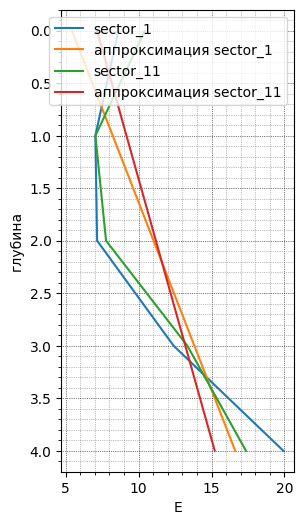

In [41]:
plt.figure(figsize=(3, 6))
plt.xlabel('E')
plt.ylabel('глубина')
plt.gca().invert_yaxis()
plt.grid(which='major', linestyle=':', linewidth='0.5', color='black')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
plt.minorticks_on()
for i in [0, 10]:#matrix_result.shape[0]):
    data_now = matrix_result[i, i, :]
    plt.plot(data_now, np.where(data_now)[0], label=f"sector_{i+1}")
    coeffs = np.polyfit(np.where(data_now)[0], data_now, 1)
    poly = np.poly1d(coeffs)
    plt.plot(poly(np.where(data_now)[0]), np.where(data_now)[0], label=f"аппроксимация sector_{i+1}")
    print(coeffs)
plt.legend()
plt.show()

## Кригинг по всем точкам

In [42]:
"""
По всем точкам
"""
result_r2_count = {}
result_tables = []

for group in range(65, 74, 2):
    """
    Разбивка определенных скважин
    """
    df_now = group_E.query('group == @group')
    data_train = df_now.copy()

    p_train = data_train.loc[:, ["x", "y"]].to_numpy()
    x_train = data_train.loc[:, ["x", "y"]].to_numpy()
    target_train = data_train.loc[:, ["E"]].to_numpy().reshape(-1)
    """
    Кригинг
    """
    x = x_train[:, 0]
    y = x_train[:, 1]
    E = target_train

    OK = UniversalKriging(x_train[:, 0], 
                          x_train[:, 1], 
                          target_train, 
                          variogram_model=model,
                          variogram_parameters={'sill':28, 'range': 50, 'nugget': 1}
                         )



    x_new = np.linspace(np.min(x_train[:, 0]), np.max(x_train[:, 0]), 50)
    y_new = np.linspace(np.min(x_train[:, 1]), np.max(x_train[:, 1]), 50)

    z_new, variance = OK.execute('grid', x_new, y_new)
    X, Y = np.meshgrid(x_new, y_new)

    
    x_table = X.reshape(-1)
    y_table = Y.reshape(-1)
    E_table = z_new.reshape(-1)
    result_tables.append(pd.DataFrame({"E": E_table,
                                       "x": x_table,
                                       "y": y_table,
                                       "z": [group]*2500})
                        )
matrix_result = None

for i in range(len(result_tables)):
    df_table = result_tables[i].copy()
    df_table["x"] = (df_table["x"] - df_table["x"].min())/3
    df_table["y"] = (df_table["y"] - df_table["y"].min())/3
    df_table["x_i"] = df_table["x"]//2.5
    df_table["y_i"] = df_table["y"]//2.5
    max_x = df_table["x_i"].unique().shape[0]
    max_y = df_table["y_i"].unique().shape[0]
    #print(max_x, max_y)
    df_table = df_table.groupby(by=["x_i", "y_i"]).mean()
    #print(df_table[])
    if matrix_result is None:
        #matrix_result = np.array((max_x, max_y, 1))
        matrix_result = df_table.loc[:, "E"].to_numpy().reshape(max_x, max_y, 1)
    else:
        matrix_result = np.concatenate([matrix_result, df_table.loc[:, "E"].to_numpy().reshape(max_x, max_y, 1)], axis=2)

x_list = []
y_list = []
h_list = []
E_list = []
for i in range(matrix_result.shape[0]):
    for j in range(matrix_result.shape[1]):
        h_list += [i+2 for i in range(matrix_result.shape[2])]
        E_list += list(matrix_result[i, j, :])
        x_list += [i] * matrix_result.shape[2]
        y_list += [j] * matrix_result.shape[2]

print(len(E_list))        
df_space_3d = pd.DataFrame({"xi": x_list, "yi": y_list, "zi": h_list, "E0": E_list})
df_space_3d.to_excel("data/E_uk_all_3d.xlsx")

780


[2.63091001 5.29866331]
[1.94160604 7.3317913 ]


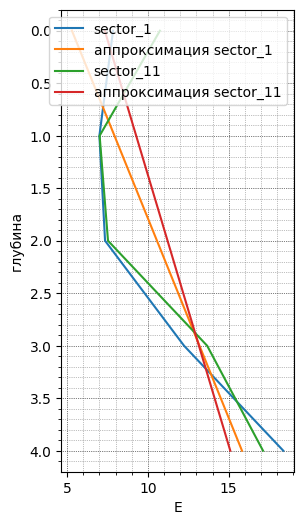

In [43]:
plt.figure(figsize=(3, 6))
plt.xlabel('E')
plt.ylabel('глубина')
plt.gca().invert_yaxis()
plt.grid(which='major', linestyle=':', linewidth='0.5', color='black')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
plt.minorticks_on()
for i in [0, 10]:#matrix_result.shape[0]):
    data_now = matrix_result[i, i, :]
    plt.plot(data_now, np.where(data_now)[0], label=f"sector_{i+1}")
    coeffs = np.polyfit(np.where(data_now)[0], data_now, 1)
    poly = np.poly1d(coeffs)
    plt.plot(poly(np.where(data_now)[0]), np.where(data_now)[0], label=f"аппроксимация sector_{i+1}")
    print(coeffs)
plt.legend()
plt.show()

## Линейная модель

In [44]:
"""
Линейная модель
"""
result_r2_count = {}
result_tables = []

for group in range(65, 74, 2):
    """
    Разбивка определенных скважин
    """
    df_now = group_E.query('group == @group')
    boreholes_train = list(range(51, 131, 4))
    data_train = df_now.query('borehole in @boreholes_train')
    data_test = df_now.query('borehole not in @boreholes_train')

    p_train = data_train.loc[:, ["x", "y"]].to_numpy()
    p_test = data_test.loc[:, ["x", "y"]].to_numpy()
    x_train = data_train.loc[:, ["x", "y"]].to_numpy()
    x_test = data_test.loc[:, ["x", "y"]].to_numpy()
    target_train = data_train.loc[:, ["E"]].to_numpy().reshape(-1)
    target_test = data_test.loc[:, ["E"]].to_numpy().reshape(-1)
    """
    ML
    """
    model = TweedieRegressor()
    model.fit(p_train, target_train)
    predict_test = model.predict(p_test)
    print(target_train.shape, my_R2(target_test, predict_test, np.mean(target_train)))
    result_r2_count[len(boreholes_train)] = [r2_score(target_test, predict_test), 
                                             my_R2(target_test, predict_test, np.mean(target_train))
                                            ]
    
    
    x_new = np.linspace(np.min(x_train[:, 0]), np.max(x_train[:, 0]), 50)
    y_new = np.linspace(np.min(x_train[:, 1]), np.max(x_train[:, 1]), 50)
    X, Y = np.meshgrid(x_new, y_new)
    x_table = X.reshape(-1)
    y_table = Y.reshape(-1)
    
    z_new = model.predict(np.array([x_table, y_table]).T)

    E_table = z_new.reshape(-1)
    result_tables.append(pd.DataFrame({"E": E_table,
                                       "x": x_table,
                                       "y": y_table,
                                       "z": [group]*2500})
                        )

matrix_result = None

for i in range(len(result_tables)):
    df_table = result_tables[i].copy()
    df_table["x"] = (df_table["x"] - df_table["x"].min())/3
    df_table["y"] = (df_table["y"] - df_table["y"].min())/3
    df_table["x_i"] = df_table["x"]//2.5
    df_table["y_i"] = df_table["y"]//2.5
    max_x = df_table["x_i"].unique().shape[0]
    max_y = df_table["y_i"].unique().shape[0]
    print(max_x, max_y)
    df_table = df_table.groupby(by=["x_i", "y_i"]).mean()
    #print(df_table[])
    if matrix_result is None:
        #matrix_result = np.array((max_x, max_y, 1))
        matrix_result = df_table.loc[:, "E"].to_numpy().reshape(max_x, max_y, 1)
    else:
        matrix_result = np.concatenate([matrix_result, df_table.loc[:, "E"].to_numpy().reshape(max_x, max_y, 1)], axis=2)
        

x_list = []
y_list = []
h_list = []
E_list = []
for i in range(matrix_result.shape[0]):
    for j in range(matrix_result.shape[1]):
        h_list += [i+2 for i in range(matrix_result.shape[2])]
        E_list += list(matrix_result[i, j, :])
        x_list += [i] * matrix_result.shape[2]
        y_list += [j] * matrix_result.shape[2]

df_space_3d = pd.DataFrame({"xi": x_list, "yi": y_list, "zi": h_list, "E0": E_list})
df_space_3d.to_excel("data/E_tr_3d.xlsx")

(20,) 0.1645301964510102
(20,) 0.00010814758434407601
(20,) 0.048223021617377015
(20,) 0.2546438666369505
(20,) -0.013094334054246204
12 13
12 13
12 13
12 13
12 13


[2.18411271 6.45477867]
[1.34166906 8.46725759]


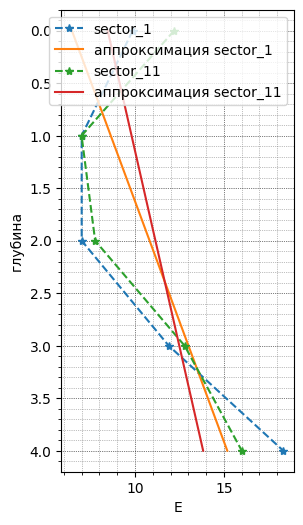

In [45]:
plt.figure(figsize=(3, 6))
plt.xlabel('E')
plt.ylabel('глубина')
plt.gca().invert_yaxis()
plt.grid(which='major', linestyle=':', linewidth='0.5', color='black')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
plt.minorticks_on()
for i in [0, 10]:#matrix_result.shape[0]):
    data_now = matrix_result[i, i, :]
    plt.plot(data_now, np.where(data_now)[0], "--*",label=f"sector_{i+1}")
    coeffs = np.polyfit(np.where(data_now)[0], data_now, 1)
    poly = np.poly1d(coeffs)
    plt.plot(poly(np.where(data_now)[0]), np.where(data_now)[0], label=f"аппроксимация sector_{i+1}")
    print(coeffs)
plt.legend()
plt.show()

## Полином

In [46]:
result_r2_count = {}
result_tables = []

model = LinearRegression()
poly_features = PolynomialFeatures(degree=2, include_bias=False)

for group in range(65, 74, 2):
    """
    Разбивка определенных скважин
    """
    df_now = group_E.query('group == @group')
    boreholes_train = list(range(51, 131, 4))
    data_train = df_now.query('borehole in @boreholes_train')
    data_test = df_now.query('borehole not in @boreholes_train')

    p_train = data_train.loc[:, ["x", "y"]].to_numpy()
    p_test = data_test.loc[:, ["x", "y"]].to_numpy()
    x_train = data_train.loc[:, ["x", "y"]].to_numpy()
    x_test = data_test.loc[:, ["x", "y"]].to_numpy()
    target_train = data_train.loc[:, ["E"]].to_numpy().reshape(-1)
    target_test = data_test.loc[:, ["E"]].to_numpy().reshape(-1)
    """
    ML
    """
    X_poly = poly_features.fit_transform(np.c_[x_train[:, 0], x_train[:, 1]])

    model.fit(X_poly, target_train)
    
    coeffs = model.coef_
    test_X_poly = poly_features.transform(np.c_[x_test[:, 0], x_test[:, 1]])
    predict_test = model.predict(test_X_poly)
    
    print(target_train.shape, my_R2(target_test, predict_test, np.mean(target_train)))
    result_r2_count[len(boreholes_train)] = [r2_score(target_test, predict_test), 
                                             my_R2(target_test, predict_test, np.mean(target_train))
                                            ]
    
    
    x_new = np.linspace(np.min(x_train[:, 0]), np.max(x_train[:, 0]), 50)
    y_new = np.linspace(np.min(x_train[:, 1]), np.max(x_train[:, 1]), 50)
    X, Y = np.meshgrid(x_new, y_new)
    x_table = X.reshape(-1)
    y_table = Y.reshape(-1)
    
    test_X_poly = poly_features.transform(np.c_[x_table, y_table])
    z_new = model.predict(test_X_poly)

    E_table = z_new.reshape(-1)
    result_tables.append(pd.DataFrame({"E": E_table,
                                       "x": x_table,
                                       "y": y_table,
                                       "z": [group]*2500})
                        )

matrix_result = None

for i in range(len(result_tables)):
    df_table = result_tables[i].copy()
    df_table["x"] = (df_table["x"] - df_table["x"].min())/3
    df_table["y"] = (df_table["y"] - df_table["y"].min())/3
    df_table["x_i"] = df_table["x"]//2.5
    df_table["y_i"] = df_table["y"]//2.5
    max_x = df_table["x_i"].unique().shape[0]
    max_y = df_table["y_i"].unique().shape[0]
    print(max_x, max_y)
    df_table = df_table.groupby(by=["x_i", "y_i"]).mean()
    #print(df_table[])
    if matrix_result is None:
        #matrix_result = np.array((max_x, max_y, 1))
        matrix_result = df_table.loc[:, "E"].to_numpy().reshape(max_x, max_y, 1)
    else:
        matrix_result = np.concatenate([matrix_result, df_table.loc[:, "E"].to_numpy().reshape(max_x, max_y, 1)], axis=2)
        

x_list = []
y_list = []
h_list = []
E_list = []
for i in range(matrix_result.shape[0]):
    for j in range(matrix_result.shape[1]):
        h_list += [i+2 for i in range(matrix_result.shape[2])]
        E_list += list(matrix_result[i, j, :])
        x_list += [i] * matrix_result.shape[2]
        y_list += [j] * matrix_result.shape[2]

df_space_3d = pd.DataFrame({"xi": x_list, "yi": y_list, "zi": h_list, "E0": E_list})
df_space_3d.to_excel("data/E_poly_3d.xlsx")

(20,) 0.34936491450946694
(20,) 0.0270885175055513
(20,) -0.00016288550535348278
(20,) -0.011089247643615296
(20,) -0.3811103643022986
12 13
12 13
12 13
12 13
12 13


[3.02020305 4.74569559]
[1.93683338 7.54606232]


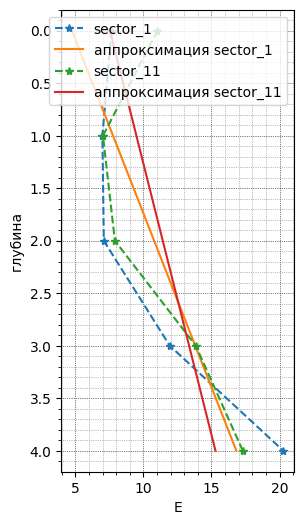

In [47]:
plt.figure(figsize=(3, 6))
plt.xlabel('E')
plt.ylabel('глубина')
plt.gca().invert_yaxis()
plt.grid(which='major', linestyle=':', linewidth='0.5', color='black')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
plt.minorticks_on()
for i in [0, 10]:#matrix_result.shape[0]):
    data_now = matrix_result[i, i, :]
    plt.plot(data_now, np.where(data_now)[0], "--*",label=f"sector_{i+1}")
    coeffs = np.polyfit(np.where(data_now)[0], data_now, 1)
    poly = np.poly1d(coeffs)
    plt.plot(poly(np.where(data_now)[0]), np.where(data_now)[0], label=f"аппроксимация sector_{i+1}")
    print(coeffs)
plt.legend()
plt.show()